In [1]:
# var inspector (install in anaconda prompt):
#   conda install -c conda-forge jupyterlab-variableinspector

In [1]:
# %conda install tensorflow
# %conda install tensorflow-gpu
# %conda install numpy
# %conda install pandas
# %conda install -c conda-forge matplotlib
# %conda install keras
# %conda install Pillow

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Pikam\anaconda3\envs\tfgpu

  added / updated specs:
    - matplotlib


The following NEW packages will be INSTALLED:

  brotli             conda-forge/win-64::brotli-1.0.9-h8ffe710_7
  brotli-bin         conda-forge/win-64::brotli-bin-1.0.9-h8ffe710_7
  cycler             conda-forge/noarch::cycler-0.11.0-pyhd8ed1ab_0
  fonttools          conda-forge/win-64::fonttools-4.33.3-py39hb82d6ee_0
  freetype           conda-forge/win-64::freetype-2.10.4-h546665d_1
  kiwisolver         conda-forge/win-64::kiwisolver-1.4.2-py39h2e07f2f_1
  libbrotlicommon    conda-forge/win-64::libbrotlicommon-1.0.9-h8ffe710_7
  libbrotlidec       conda-forge/win-64::libbrotlidec-1.0.9-h8ffe710_7
  libbrotlienc       conda-forge/win-64::libbrotlienc-1.0.9-h8ffe710_7
  

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13832638609529015904,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5767102464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12095760840254656970
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [3]:
tf.debugging.set_log_device_placement(False)

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [5]:
# image size: 1080*1920
INPUT_HEIGHT = 216
INPUT_WIDTH = 384
INPUT_CHANNEL = 3
INPUT_SHAPE = (INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)

In [6]:
import glob
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/stimuli.out/'
def x_from_dir(dir_name):
    x_paths = glob.glob(dir_name + '*.jpg', recursive=False)
    
    # initialize
    first_img = load_img(x_paths[0], target_size=(INPUT_HEIGHT, INPUT_WIDTH))
    x = img_to_array(first_img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)
    # remaining
    for path in x_paths[1:]:
        img = load_img(path, target_size=(INPUT_HEIGHT, INPUT_WIDTH))
        arr = img_to_array(img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH, INPUT_CHANNEL)
        x = np.append(x, arr, axis=0)

    return x / 255

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/heatmap/'
def y_from_dir(dir_name):
    y_paths = glob.glob(dir_name + '*_heatmap.png', recursive=False)
    
    # initialize
    first_img = load_img(y_paths[0], color_mode='grayscale', target_size=(INPUT_HEIGHT, INPUT_WIDTH))
    y = img_to_array(first_img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH,1)
    # remaining
    for path in y_paths[1:]:
        img = load_img(path, color_mode='grayscale', target_size=(INPUT_HEIGHT, INPUT_WIDTH))
        arr = img_to_array(img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH,1)
        y = np.append(y, arr, axis=0)

    return y / 256

In [7]:
x_dir = 'data/stimuli.out/'
x = x_from_dir(x_dir)
y_dir = 'data/heatmap/'
y = y_from_dir(y_dir)

In [8]:
# slice all data
TRAIN_SIZE = 270
x_train = x[:TRAIN_SIZE]
x_test = x[TRAIN_SIZE:]
y_train = y[:TRAIN_SIZE]
y_test = y[TRAIN_SIZE:]

In [84]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(layers.MaxPooling2D((3, 3), padding='same'))
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(96, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(96, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (11, 11), activation='relu', padding='same'))
model.add(layers.Conv2D(1, (13, 13), activation='relu', padding='same'))
model.add(layers.UpSampling2D((6, 6)))

# model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [85]:
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
27/27 [==============================] - 2s 28ms/step - loss: 0.2448 - accuracy: 0.6870
Epoch 2/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1550 - accuracy: 0.6985
Epoch 3/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1531 - accuracy: 0.6985
Epoch 4/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1528 - accuracy: 0.6985
Epoch 5/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1522 - accuracy: 0.6985
Epoch 6/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1501 - accuracy: 0.6985
Epoch 7/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1500 - accuracy: 0.6985
Epoch 8/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1500 - accuracy: 0.6985
Epoch 9/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1495 - accuracy: 0.6985
Epoch 10/10
27/27 [==============================] - 1s 24ms/step - loss: 0.1493 - accuracy: 0.6985


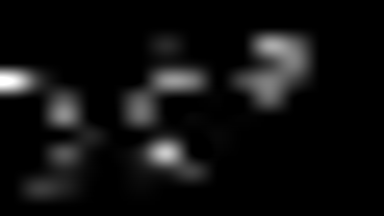

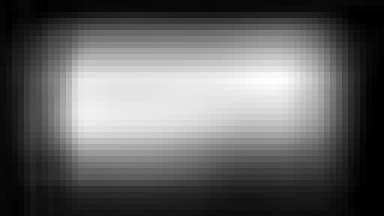

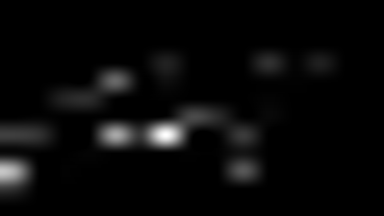

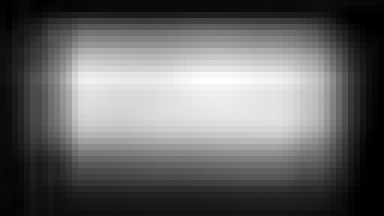

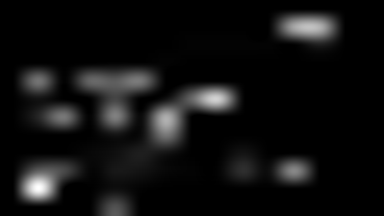

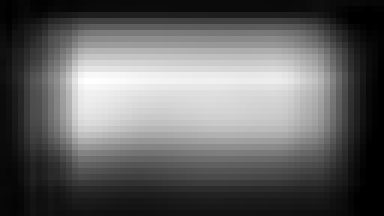

In [86]:
from tensorflow.keras.utils import array_to_img
y_pred = model.predict(x_test)
for i in range(6,9):
    pred_img = array_to_img(y_pred[i])
    display(array_to_img(y_test[i]))
    display(pred_img)

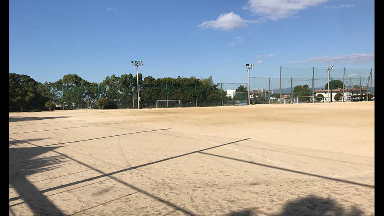

In [21]:
display(array_to_img(x_test[1]))

In [33]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input
input_tensor = Input(shape=INPUT_SHAPE)
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 270, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 67, 120, 128)      0     